In [1]:
import numpy as np
import pandas as pd
import math
import re

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# E-Commerce Furniture Sales

### Dataset Source:
https://www.kaggle.com/datasets/kanchana1990/e-commerce-furniture-dataset-2024

In [2]:
df = pd.read_csv(r"C:\Users\Public\MyData\ecommerce_furniture_dataset_2024.csv")
df.head(15)

,productTitle,originalPrice,price,sold,tagText
0,Dresser For Bedroom With 9 Fabric Drawers Ward...,NaN,$46.79,600,Free shipping
1,Outdoor Conversation Set 4 Pieces Patio Furnit...,NaN,$169.72,0,Free shipping
2,Desser For Bedroom With 7 Fabric Drawers Organ...,$78.4,$39.46,7,Free shipping
3,"Modern Accent Boucle Chair,Upholstered Tufted ...",NaN,$111.99,0,Free shipping
4,Small Unit Simple Computer Desk Household Wood...,$48.82,$21.37,1,Free shipping
5,"3 Pieces Patio Furniture Set, Outdoor Swivel G...","$1,294.04",$123.4,53,Free shipping
6,5-Piece Patio Furniture Set Outdoor Couch with...,NaN,$198.31,1,Free shipping
7,"Living Room Furniture, Modern 3-Piece Includin...","$1,474.17",$734.58,5,Free shipping
8,TV Stand Dresser For Bedroom With 5 Fabric Dra...,NaN,$43.96,3,NaN
9,Outdoor Furniture Set 3 Pieces Wicker Patio Fu...,NaN,$233.3,0,Free shipping


### Data Exploration and Cleaning

In [3]:
df = df.rename(columns={"productTitle": "Furniture Product", "originalPrice": "Original Price ($)", "price": "Price ($)", "sold": "Units Sold", "tagText": "Shipping ($)"})
df.head() # columns are renamed for ease of interpretation

,Furniture Product,Original Price ($),Price ($),Units Sold,Shipping ($)
0,Dresser For Bedroom With 9 Fabric Drawers Ward...,NaN,$46.79,600,Free shipping
1,Outdoor Conversation Set 4 Pieces Patio Furnit...,NaN,$169.72,0,Free shipping
2,Desser For Bedroom With 7 Fabric Drawers Organ...,$78.4,$39.46,7,Free shipping
3,"Modern Accent Boucle Chair,Upholstered Tufted ...",NaN,$111.99,0,Free shipping
4,Small Unit Simple Computer Desk Household Wood...,$48.82,$21.37,1,Free shipping


In [452]:
print(f"Shape of dataframe: {df.shape}")

Shape of dataframe: (2000, 5)


In [454]:
df.info()
# We see that the price columns contain strings
# however, want to be able to work with the price columns as floats

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Furniture Product   2000 non-null   object
 1   Original Price ($)  487 non-null    object
 2   Price ($)           2000 non-null   object
 3   Units Sold          2000 non-null   int64 
 4   Shipping ($)        1997 non-null   object
dtypes: int64(1), object(4)
memory usage: 78.3+ KB


In [456]:
df.isnull().sum()

Furniture Product        0
Original Price ($)    1513
Price ($)                0
Units Sold               0
Shipping ($)             3
dtype: int64

In [458]:
# Creating a small dataframe containing all the rows where 'Original Price ($)' is not null
df_original_price = df[df["Original Price ($)"].notnull()] # alternative: .notna()
df_original_price

,Furniture Product,Original Price ($),Price ($),Units Sold,Shipping ($)
2,Desser For Bedroom With 7 Fabric Drawers Organ...,$78.4,$39.46,7,Free shipping
4,Small Unit Simple Computer Desk Household Wood...,$48.82,$21.37,1,Free shipping
5,"3 Pieces Patio Furniture Set, Outdoor Swivel G...","$1,294.04",$123.4,53,Free shipping
7,"Living Room Furniture, Modern 3-Piece Includin...","$1,474.17",$734.58,5,Free shipping
20,7-piece patio furniture set modular wicker out...,$671.47,$331.24,39,Free shipping
...,...,...,...,...,...
1938,"5 Piece Patio Conversation Set, Wicker Rattan ...",$392.22,$232.83,5,Free shipping
1948,Vanity Table Set with Mirror 2 Storage Drawer ...,$135.02,$102.02,1,Free shipping
1955,"White Vanity Desk with Mirror, Lights and Char...",$950.85,$188.67,11,Free shipping
1964,PP Folding Stools Portable Lightweight Chairs ...,$7.27,$1.27,9,Free shipping


In [460]:
print(df_original_price.shape)
df_original_price.isnull().sum() # no nulls

(487, 5)


Furniture Product     0
Original Price ($)    0
Price ($)             0
Units Sold            0
Shipping ($)          0
dtype: int64

In [462]:
def clean_monetary(s):
    """This function will be used for string cleaning of the
    'Original Price ($)', 'Price ($)' and 'Shipping ($)' columns."""
    cleaned_string = re.sub(r'[^0-9.]', '', s) # regex to remove characters that aren't digits or period .
    try:
        return float(cleaned_string)
    except ValueError:
        return 0.0   # if string has no digits or periods (e.g., "Free shipping"), return the float 0.0

In [464]:
# cleaning monetary columns for df_original_price
cols_to_clean = ["Original Price ($)", "Price ($)", "Shipping ($)"]
for c in cols_to_clean:
    df_original_price.loc[:, c] = df_original_price[c].apply(clean_monetary)

df_original_price.head()

,Furniture Product,Original Price ($),Price ($),Units Sold,Shipping ($)
2,Desser For Bedroom With 7 Fabric Drawers Organ...,78.4,39.46,7,0.0
4,Small Unit Simple Computer Desk Household Wood...,48.82,21.37,1,0.0
5,"3 Pieces Patio Furniture Set, Outdoor Swivel G...",1294.04,123.4,53,0.0
7,"Living Room Furniture, Modern 3-Piece Includin...",1474.17,734.58,5,0.0
20,7-piece patio furniture set modular wicker out...,671.47,331.24,39,0.0


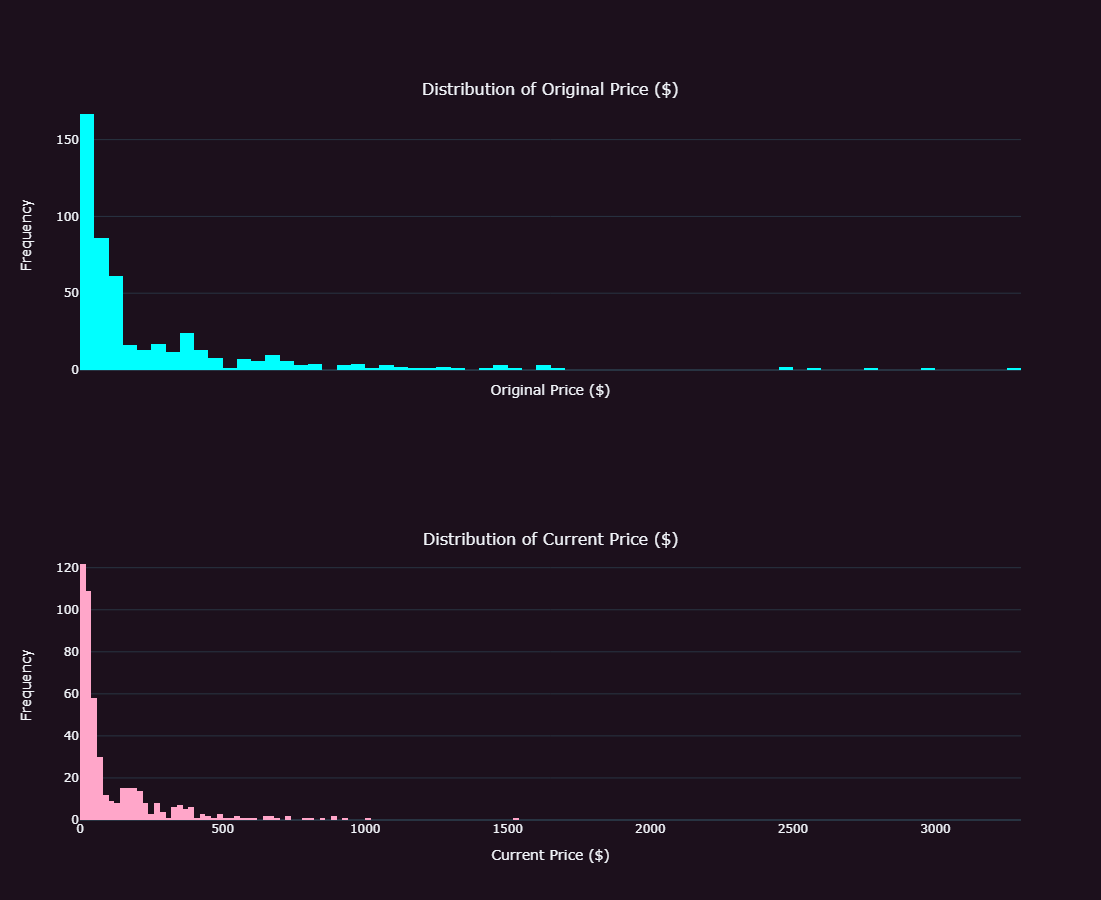

In [466]:
fig = make_subplots(rows=2, cols=1, shared_xaxes=True,  # align the x-axes for correct scale
                    subplot_titles=("Distribution of Original Price ($)", "Distribution of Current Price ($)"))

fig.add_trace(go.Histogram(x=df_original_price["Original Price ($)"], nbinsx=120, marker_color='cyan', showlegend=False), row=1, col=1)

fig.add_trace(go.Histogram(x=df_original_price["Price ($)"], nbinsx=80, marker_color='#ffa6c9', showlegend=False), row=2, col=1)

fig.update_layout(template="plotly_dark", paper_bgcolor='#1c101c', plot_bgcolor='#1c101c',
                  xaxis_title="", yaxis_title="Frequency", title_font=dict(size=22, color='white'), height=900, width=1100)

fig.update_xaxes(title_text="Original Price ($)", row=1, col=1)
fig.update_xaxes(title_text="Current Price ($)", row=2, col=1)
fig.update_yaxes(title_text="Frequency", row=1, col=1)
fig.update_yaxes(title_text="Frequency", row=2, col=1)
fig.show()

In [468]:
orig_over_price = df_original_price["Original Price ($)"].mean()/df_original_price["Price ($)"].mean()
null_proportion = df['Original Price ($)'].isnull().sum()/len(df) * 100 
print(f"We observe that the values in 'Original Price ($)' are often roughly {orig_over_price:.2f} times the values "
      f"\nin 'Price ($)', so imputing may be considered."
      f"\n\nHowever, in some rows, the 'Original Price ($)' is much more than {orig_over_price:.0f} times the 'Price ($)', and in "
      f"\nother rows, it's much less than {orig_over_price:.0f} times the 'Price ($)'. Since the variability amongst values is "
      f"\nlarge and {null_proportion:.2f}% of it is missing, we will drop the 'Original Price ($)' column.")

We observe that the values in 'Original Price ($)' are often roughly 2.12 times the values 
in 'Price ($)', so imputing may be considered.

However, in some rows, the 'Original Price ($)' is much more than 2 times the 'Price ($)', and in 
other rows, it's much less than 2 times the 'Price ($)'. Since the variability amongst values is 
large and 75.65% of it is missing, we will drop the 'Original Price ($)' column.


In [470]:
df.drop(columns=['Original Price ($)'], inplace=True)
df.head()

,Furniture Product,Price ($),Units Sold,Shipping ($)
0,Dresser For Bedroom With 9 Fabric Drawers Ward...,$46.79,600,Free shipping
1,Outdoor Conversation Set 4 Pieces Patio Furnit...,$169.72,0,Free shipping
2,Desser For Bedroom With 7 Fabric Drawers Organ...,$39.46,7,Free shipping
3,"Modern Accent Boucle Chair,Upholstered Tufted ...",$111.99,0,Free shipping
4,Small Unit Simple Computer Desk Household Wood...,$21.37,1,Free shipping


In [472]:
df["Shipping ($)"].unique()

array(['Free shipping', nan, '+Shipping: $12.03', '+Shipping: $29.45',
       '+Shipping: $36.4', '+Shipping: $86.91', '+Shipping: $225.12',
       '+Shipping: $7.8', '+Shipping: $29.52', '+Shipping: $38.07',
       '+Shipping: $104.89', '+Shipping: $239.64', '+Shipping: $41.19',
       '+Shipping: $18.44', '+Shipping: $80.21', '+Shipping: $5.09',
       '+Shipping: $110.64', '+Shipping: $64.01', '+Shipping: $150.28',
       '+Shipping: $129.03', '+Shipping: $52.63', '+Shipping: $76.6',
       '+Shipping: $210.53', '+Shipping: $64.56', '+Shipping: $120.25',
       '+Shipping: $5.39', '+Shipping: $4.74', '+Shipping: $258.18',
       '+Shipping: $72.79', '+Shipping: $168.91', '+Shipping: $109.18',
       '+Shipping: $106.13', '+Shipping: $94.92', '+Shipping: $1,097.18',
       '+Shipping: $170.31', '+Shipping: $88.26', '+Shipping: $23.49',
       '+Shipping: $30.44', '+Shipping: $14.97', '+Shipping: $75.99',
       '+Shipping: $14.91', '+Shipping: $18.81', '+Shipping: $69.95',
       '+S

In [474]:
df["Price ($)"] = df["Price ($)"].apply(clean_monetary)
df.head() # Price ($) column now contains float values

,Furniture Product,Price ($),Units Sold,Shipping ($)
0,Dresser For Bedroom With 9 Fabric Drawers Ward...,46.79,600,Free shipping
1,Outdoor Conversation Set 4 Pieces Patio Furnit...,169.72,0,Free shipping
2,Desser For Bedroom With 7 Fabric Drawers Organ...,39.46,7,Free shipping
3,"Modern Accent Boucle Chair,Upholstered Tufted ...",111.99,0,Free shipping
4,Small Unit Simple Computer Desk Household Wood...,21.37,1,Free shipping


In [476]:
df["Shipping ($)"].value_counts()

Shipping ($)
Free shipping           1880
+Shipping: $5.09           9
+Shipping: $239.64         2
+Shipping: $97.54          2
+Shipping: $64.56          2
                        ... 
+Shipping: $88.26          1
+Shipping: $170.31         1
+Shipping: $1,097.18       1
+Shipping: $106.13         1
+Shipping: $171.49         1
Name: count, Length: 100, dtype: int64

In [478]:
df.info() # 3 missing values in Shipping

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Furniture Product  2000 non-null   object 
 1   Price ($)          2000 non-null   float64
 2   Units Sold         2000 non-null   int64  
 3   Shipping ($)       1997 non-null   object 
dtypes: float64(1), int64(1), object(2)
memory usage: 62.6+ KB


In [480]:
mode_val = df['Shipping ($)'].mode()[0]
df['Shipping ($)'] = df['Shipping ($)'].fillna(mode_val)  # alternative: df.fillna({'Shipping Info': mode_val}, inplace=True)
df.isnull().sum() # all missing values handled (filled)

Furniture Product    0
Price ($)            0
Units Sold           0
Shipping ($)         0
dtype: int64

In [482]:
df["Shipping ($)"].value_counts() # count of the mode value increased as expected

Shipping ($)
Free shipping           1883
+Shipping: $5.09           9
+Shipping: $239.64         2
+Shipping: $97.54          2
+Shipping: $64.56          2
                        ... 
+Shipping: $88.26          1
+Shipping: $170.31         1
+Shipping: $1,097.18       1
+Shipping: $106.13         1
+Shipping: $171.49         1
Name: count, Length: 100, dtype: int64

In [484]:
df["Shipping ($)"] = df["Shipping ($)"].apply(clean_monetary)
df.info()   # Shipping ($) column now contains float values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Furniture Product  2000 non-null   object 
 1   Price ($)          2000 non-null   float64
 2   Units Sold         2000 non-null   int64  
 3   Shipping ($)       2000 non-null   float64
dtypes: float64(2), int64(1), object(1)
memory usage: 62.6+ KB


In [486]:
df.describe().T.rename(columns={"50%":"median"})
# R-skewed: Mean > Median (tail to R)
# L-skewed: Mean < Median (tail to L)
# Price, Units Sold, Shipping are all R-skewed

,count,mean,std,min,25%,median,75%,max
Price ($),2000.0,156.560020,176.936735,0.99,48.53,114.08,193.49,2876.38
Units Sold,2000.0,23.493500,254.094061,0.00,1.00,3.00,9.00,10000.00
Shipping ($),2000.0,7.337555,57.309449,0.00,0.00,0.00,0.00,1323.31


In [488]:
df['Furniture Product'].nunique() # 1793 distinct products from 2000 rows

1793

### Perform Custom Aggregation for Products that occur in Multiple Rows

In [491]:
df['Furniture Product'].value_counts() # see which products occur in multiple rows

Furniture Product
3 Pieces Rocking Wicker Bistro Set, Patio Outdoor Furniture Conversation Sets with Porch Chairs and Glass Coffee Table, Beige       6
Makeup Vanity Table Set Glass Top Makeup Vanity Table With 10x Magnifying Mirror 3 Light Settings (Modern White) Furnitures Desk    5
Makeup Table Makeup Vanity With Lights Make Up Table 2 Cabinets & Long Storage Shelf Furniture Bathroom 10 Led Lights White Desk    5
Dressing Table for Bedroom Furniture Home 4 Cabinets & Time Display Makeup Vanity Table Set Vanity Desk With Mirror and Lights      4
Vanity Desk With Stool Makeup Vanity Table Set 3 Color Lighting Modes Brightness Adjustable Dressers for Bedroom Furniture Girls    4
                                                                                                                                   ..
Egg Chair with Stand, Hammock Hanging Chair Nest Basket & Washable Cushions UV Resistant Removable,350LBS Capacity Egg Chair        1
Modern Makeup Dressing Table with Adjustable

In [493]:
df = df.sort_values(by=['Furniture Product']).reset_index(drop=True)
df.tail(60) # looking at adjacent rows that have same Furniture Product
df.head(60)

,Furniture Product,Price ($),Units Sold,Shipping ($)
0,1 Stainless Steel Shoe Rack 3-Layer Tower Stor...,7.15,41,0.00
1,1 folding chair for home and outdoor use Conve...,0.99,85,0.00
2,1 set - Household Simple Multi-layer Space-sav...,5.49,64,0.00
3,1/12 Scale mini house Miniature Round Wooden C...,0.99,23,0.00
4,1/2/3PCS Plastic Folding Step Stool Portable F...,8.34,1,0.00
5,10 Drawers Dresser Fabric Storage Tower Cabine...,60.33,2,0.00
6,"10 Tier Shoe Rack with Covers,Large Capacity S...",44.43,20,0.00
7,"104"" Linen Fabric Sofa with Armrest Pockets an...",308.16,7,0.00
8,"104"" Linen Fabric Sofa with Armrest Pockets an...",308.16,7,0.00
9,"11-Tier Shoe Storage Cabinet, 31 Open Cubbie S...",121.45,5,0.00


In [495]:
# our custom rules for aggregation where multiple rows contain same Furniture Product: 
# get the sum of Units Sold
# get the weighted average of Price ($). (weighting according to Units Sold)
# get the weighted average of Shipping ($). (weighting according to Units Sold)

def weighted_mean(tbl, v_col, w_col):
    if tbl[w_col].sum() == 0: # if Units Sold is 0 for all rows of a given product, compute regular mean for Price, Shipping
        regular_avg = tbl[v_col].sum() / len(tbl[v_col]) 
        return regular_avg       # this handles (prevents) division by 0
    else:
        weighted_avg = (tbl[v_col] * tbl[w_col]).sum() / tbl[w_col].sum()
        return weighted_avg

def custom_agg(tbl):
    return pd.Series({
        'Mean Price per Unit ($)': weighted_mean(tbl, 'Price ($)', 'Units Sold'),
        'Total Units Sold': tbl['Units Sold'].sum(),
        'Mean Shipping Price per Unit ($)': weighted_mean(tbl, 'Shipping ($)', 'Units Sold')
    }) # note: this func would aggregate the whole table if not used along with groupby('Furniture Product')

df_aggregated = df.groupby("Furniture Product").apply(custom_agg, include_groups=False).round(2).reset_index()
df_aggregated

,Furniture Product,Mean Price per Unit ($),Total Units Sold,Mean Shipping Price per Unit ($)
0,1 Stainless Steel Shoe Rack 3-Layer Tower Stor...,7.15,41.0,0.0
1,1 folding chair for home and outdoor use Conve...,0.99,85.0,0.0
2,1 set - Household Simple Multi-layer Space-sav...,5.49,64.0,0.0
3,1/12 Scale mini house Miniature Round Wooden C...,0.99,23.0,0.0
4,1/2/3PCS Plastic Folding Step Stool Portable F...,8.34,1.0,0.0
...,...,...,...,...
1788,"living room sofas Sectional Sofa, Modular Sect...",1197.77,0.0,0.0
1789,"sofasSet, Modular Sectional Sofa with Reversib...",248.60,16.0,0.0
1790,trolley organizer Storage cabinet for multiple...,116.47,35.0,0.0
1791,usikey Vanity Desk Set with Large Lighted Mirr...,99.86,1.0,0.0


In [497]:
df_aggregated['Total Units Sold'] = df_aggregated['Total Units Sold'].astype(int)
df_aggregated.info() # values aggregated, no missing values, correct dtypes

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1793 entries, 0 to 1792
Data columns (total 4 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Furniture Product                 1793 non-null   object 
 1   Mean Price per Unit ($)           1793 non-null   float64
 2   Total Units Sold                  1793 non-null   int32  
 3   Mean Shipping Price per Unit ($)  1793 non-null   float64
dtypes: float64(2), int32(1), object(1)
memory usage: 49.2+ KB


### Natural Language Processing to make the Furniture Product names insightful towards assigning Product Categories

In [ ]:
# gather all words in the Furniture Product column, removing anything that's not letters

# find the 8 most popular words

# remove stop words: custom stop words - domain relevant: and, set, for, etc. 

# find the 8 most popular words

# find out if at least one of those words occur in every single row of df_aggregated, else mark rows that don't fit into these as "other"

In [59]:
# product tags cols
# they will be boolean: true/false


### Building a K-Nearest Neighbors Model to predict Units Sold for each Product Category

In [253]:
# either df_aggregated or df_original_price
# use original price, current price, price diff, shipping, and product tags to predict the units sold of a product category *good business idea
# target: units sold
# use KNN for this

In [ ]:
# export csvs to take to power bi
# df_aggregated, df_original_price, df_knn_results